# Part 1: Getting the Data Ready

For the past several years I have been struggling to win a championship in my ESPN Fantasy Football League. Therefore I aim to put my software egineer, analytics and machine learning skills to the test and come up with a data driven approach to winning my league this year.

### Defining Goal - Target and Intermediate Target Variables
Success in a fantasy football league can be guaged in a variety of ways - but we only care about one thing: winning the whole thing. Therefore the main target variable will indicate for any given team in a given year, whether or not they won: 

- LeagueWin_Binary: Indicator of League Win or Not

However, considering there is only 1 winner every year and the league has only been active since 2016, a major flaw to the model could be an incredibly imbalanced dataset. In addition, I fear that there is a lot of variablity in winning that can be attribtued to plain luck. Therefore anticipating the difficulty in predicting a leauge win or not, I will also be including a list of some intermediate target variables that may serve as an alternative measure of success: 

- LeagueWin_Categorical: Categorical Variable that divides the final standings into 4 different groups: Group1: Place 1-3, Group2: Place:3-6, Group3: 6-9, and Group4: 9-12.
- LeaguePlayoffStandings_Categorical: Final playoff standings.
- LeaguePlayoff_Binary: Whether or not a team made the playoffs. 
- LeagueTotalPoints_Numerical: Numerical variable for total points scored in regular season

### Defining the Features  
There are an abundance of ways in which we can extrapolate "draft strategies", but I will be focused on type of position and ADP pre-season ranks of position picked in the various different rounds. Although it would be difficult to write a comprehensive list of all variables, here are some of the features I am interested in manufacturing. 

- FirstOverallPick_Pos - LastOverallPick_Pos: For each round, a variable indicating the position that was drafted, and the overall ranking that the player had. 
- OrderofPositionPicks_5Rounds: A sequential list of positions that were drafted from the first 5 rounds.
- AverageDraftPick_Position: The average of all the picks by a position. 
- NumberRookiePicks: Integer number of rookie selections.
- AverageAgeofPicks: Float age of overall team. 
- DiversityTeams: How many different divisions are present in the team. 
- ByeWeekDifferential: Variance of bye weeks. 
- HandcuffPicks: If a player from the same team and position are selected. 

For now, the focus on this first part will be on creating the first bullet point of variables and seeing how picks can be used to make predictive insights. Beyond that, I would also like to emphasize how important the step iof creating reliable and accurate data is as a data scientist/machine learning engineer. Yes our job is to create models and pipelines, but these outputs are entirely dependent on how clean and ready the inputted variables are. Therefore, I always take the time to massage and manufacture variables that I believe are accurately capturing intersting aspect of the problem at hand. 

Lastly, I find it helpful to understand problems in terms of dataframes. As a visual learner and data practicioner that relies heavily on pandas dataframes, I am able to better engineer data when I have a *final dataframe* that I am working towards. Therefore, in this case, I would envision the final dataframe looking something like this:w

| Team ID | LeagueWin_Binary | First_Overall_Pick_Type | ... | ByeWeekDifferential | HandcuffPicks |
|----------|----------|----------|----------|----------|----------|
| Team 1_2020 | 0   | RB   |... | 2.5   | 1   |
| Team 2_2020   | 1   | WR   |...   | 0   | 3   |

### Packages Used

In [80]:
# imporing packages
import pandas as pd
import numpy as np
import requests

# other packages
import json

# visualization packages
import seaborn as sns
from matplotlib import pyplot as plt

### Step 0: Acquiring the Data - ESPN Fantasy Football API
As with every data science project, the first step is to actually acquire the data. Although, I don't want to just amatuerly copy and paste data into an excel file. Therefore isntead, I am going to be relying on the poorly documented ESPN API to assemble the data. would much rather create a webscraper to do this for me. In order to do this, I will need to leverage a combination APIs with some "cookies" that are needed to login to my private league.

First off, its a bit tricky locating cookies, but I highly recommend visiting some of the resources that I have listed, but I found this [tutorial](https://cran.r-project.org/web/packages/ffscrapr/vignettes/espn_authentication.html) from Tan Ho the most helpful. From this you can see the two main cookies you need are the swid, and espn_s2. Just save those as a variable - as it is needed whenever submitting a get request to the ESPN APIs. 

In [79]:
SWID_COOKIE = "{38E522FE-F7B3-4D03-8F72-C2D242449408}"
ESPN_S2 = "AECU5sgX%2FnFfFx5%2BSi6I2oAW4bMhN3DtVdPvTRQI9ekv2rZG4p4VGAFV3Guav1sSgLmmw19Cyjxa4WyiTt6YmBQQfalKrtDRHa0%2FIahdIShyKyz86UyVIGYLWXXP%2BLZdIbOJ9zJMcF0BRgIkmcu3hqYaOxWiEb3beqqmnqA5LawYW%2BrBlJaVXd2pIXP2WrbhwGPO7C3RsBp3ctyE9hHNuubQUeSHKUFZlUY4iyyPLutZR4OkAYxMURQpxt2DWuCxWiE2L4LTi1iNNjMyHNToWpDXXyBn0y5hYwERRYNzfWUKFg%3D%3D"

In [80]:
# historical drafts pull
def draft_pull(league_id, year, SWID_COOKIE, ESPN_S2):
    
    print("Starting " + str(year) + " draft pull for league "+ str(league_id))
    draft_historical = "https://fantasy.espn.com/apis/v3/games/ffl/leagueHistory/" + str(league_id) + "?view=mDraftDetail&view=mSettings&view=mTeam&view=modular&view=mNav&seasonId=" + str(year)
    # requests for the url 
    r = requests.get(draft_historical, cookies = {"swid": SWID_COOKIE, "espn_s2":ESPN_S2})
    
    # request for 
    espn_draft_raw = r.json()[0]
    
    # expracting the mapping doc of member ids/names
    members_raw = pd.DataFrame(espn_draft_raw['teams'])
    
    # extracting actual picks -- limiting to only columns that we need
    draft_picks = pd.DataFrame(espn_draft_raw['draftDetail']['picks'])
    df = draft_picks[["teamId", "autoDraftTypeId", "roundId", "roundPickNumber", "overallPickNumber", "playerId", "lineupSlotId"]]

    # map the team ids to get names onto the draft
    df2 = pd.merge(df, members_raw, how="left", left_on="teamId", right_on ="id")
    
    print("Completed " + str(year) + " draft pull for league "+ str(league_id))

    return df2

# mapping an actual name for any player id
def player_map(league_id, year, SWID_COOKIE, ESPN_S2):
    
    print("Starting " + str(year) + " player detail pull for league "+ str(league_id))

    # player url
    player_info = "https://fantasy.espn.com/apis/v3/games/ffl/seasons/{}/players?scoringPeriodId=0&view=players_wl".format(year)
    
    # need this to make sure players don't get filtered out
    player_filter = {"players": 
                     {"limit": 1500,
                      "sortDraftRanks": {"sortPriority": 100, "sortAsc": True,"value": "STANDARD"}
                     }} 
    # ensures connection doesn't time out
    headers = {
        'Connection': 'keep-alive',
         'Accept': 'application/json, text/plain, */*',
         'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
         'x-fantasy-filter': json.dumps(player_filter),
         'x-fantasy-platform': 'kona-PROD-1dc40132dc2070ef47881dc95b633e62cebc9913',
         'x-fantasy-source': 'kona'}
    
    r2 = requests.get(player_info, headers=headers, cookies = {"swid": SWID_COOKIE, "espn_s2":ESPN_S2})
    player_data = r2.json()
    df2 = pd.DataFrame(player_data)
    
    print("Completed " + str(year) + " player detail pull for league "+ str(league_id))
    
    return df2

# mapping team name to each id
def team_map(league_id, year, SWID_COOKIE, ESPN_S2):
    
    print("Started " + str(year) + " team detail pull for league "+ str(league_id))

    # team url 
    team_info = "https://fantasy.espn.com/apis/v3/games/ffl/seasons/{}?view=proTeamSchedules_wl".format(year)
    
    r = requests.get(team_info, cookies = {"swid": SWID_COOKIE, "espn_s2":ESPN_S2})
    team_data = r.json()['settings']['proTeams']
    
    team_df = pd.DataFrame(team_data)
    
    team_df = team_df[['id', 'location', 'name']]
    team_df['team_name'] = team_df['location'].astype(str) +"_"+ team_df['name']
    
    # rename in column
    team_df.rename(columns = {'id':'team_id'}, inplace = True)
    
    print("Completed " + str(year) + " team detail pull for league "+ str(league_id))
    
    return team_df

In [81]:
# helper function to iterate through each year
def league_compiler(league_id, year, SWID_COOKIE, ESPN_S2):
    
    # function to call all the different necessary tables
    raw_draft = draft_pull(league_id, year, SWID_COOKIE, ESPN_S2)
    
    # function to get 
    player_details = player_map(league_id, year, SWID_COOKIE, ESPN_S2)
    team_details = team_map(league_id, year, SWID_COOKIE, ESPN_S2)
    
    # combine all the dataframes
    
    # map player ids with player_map to get player names
    df_main1 = pd.merge(raw_draft, player_details, how="left", left_on="playerId", right_on="id")
    # map team ids with team_map to get team names
    df_main2 = pd.merge(df_main1, team_details,how="left", left_on="proTeamId", right_on="team_id" )
    df_main2["year"] = year
    return df_main2

In [83]:
# league_id = 431462
# years = [2016, 2017, 2018, 2019,2020,2021,2022]

# all_years_draft = pd.DataFrame()
# for year in years: 
#     raw_draft = league_compiler(league_id, year, SWID_COOKIE, ESPN_S2)
#     all_years_draft = pd.concat([all_years_draft, raw_draft], ignore_index=True)

In [84]:
# all_years_draft.head()

In [3]:
# save the data to a csv so we don't have to do this again!
# all_years_draft.to_csv("ff_alldraft_raw.csv",  index=False)
all_years_draft = pd.read_csv("ff_alldraft_raw.csv")

### Step 1.0: Data Cleaning and Manipulation

##### Making Our Index: Team Id, Year
As mentioned earlier, we are trying to build a model that will give us insight on how to draft players to win the league. Therefore each row in our final dataframe should represent a team during a given year, and variables that encompass the drafting stratgies they used. 

In [77]:

print(all_years_draft["teamId"].unique())
print(all_years_draft["year"].unique())

# creating the main index 
all_years_draft["team_year"] = all_years_draft["teamId"].astype(str) +"_"+ all_years_draft["year"].astype(str)

[ 3  1  9  6  8  4 10 12 11  7  5  2 13 14 17 16 15 18 19]
[2016 2017 2018 2019 2020 2021 2022]


In [99]:
# creating the other target variables
def winner_indictor(row):

    if row['rankCalculatedFinal']==1:
        return 1
    else:
        return 0

def top3_indictor(row):

    if row['rankCalculatedFinal']<=2:
        return 1
    else:
        return 0
    
def split_by3_indicator(row):
    
    if row['rankCalculatedFinal']<=3:
        return 1
    elif row['rankCalculatedFinal']>3 and row['rankCalculatedFinal']<=6:
        return 2
    elif row['rankCalculatedFinal']>6 and row['rankCalculatedFinal']<=9:
        return 3
    elif row['rankCalculatedFinal']>9 and row['rankCalculatedFinal']<=12:
        return 4

# win vs no win 
all_years_draft['LeagueWin_Bin'] = all_years_draft.apply(winner_indictor, axis=1)
all_years_draft['LeagueTop2_Bin'] = all_years_draft.apply(top3_indictor, axis=1)
all_years_draft['LeagueFinish_Cat4'] = all_years_draft.apply(split_by3_indicator, axis=1)

In [105]:
all_years_draft.tail(2)

,teamId,autoDraftTypeId,roundId,roundPickNumber,overallPickNumber,playerId,lineupSlotId,abbrev,currentProjectedRank,divisionId,...,name_y,team_name,year,watchList,valuesByStat,team_year,LeagueWin_Bin,LeagueTop3_Cat,LeagueTop2_Bin,LeagueFinish_Cat4
1380,16,3,16,11,191,4372485,20,Hd,0,1,...,Cardinals,Arizona_Cardinals,2022,[],"{'128': 0.0, '129': 1.0, '130': 5.0, '4': 25.0...",16_2022,0,0,0,2
1381,14,0,16,12,192,3025433,20,FRLO,0,1,...,FA,_FA,2022,NaN,"{'128': 0.0, '129': 0.0, '130': 5.0, '4': 40.0...",14_2022,0,0,0,3


### Step 1.1 Data Exploration

**Are different positions being drafted at different rounds when winning and non winning teams?**  
The first way I can do this is by creating a boxplot. 

Text(0.5, 1.0, 'Distributions of Pick Numbers for Drafted Positions')

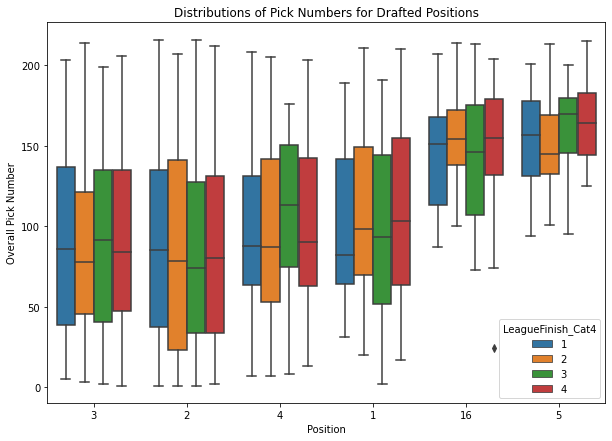

In [103]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'defaultPositionId', y = 'overallPickNumber', hue='LeagueFinish_Cat4',data = all_years_draft)
plt.xlabel("Position")
plt.ylabel("Overall Pick Number")
plt.title("Distributions of Pick Numbers for Drafted Positions")

Disapointingly, the boxplot doesn't reveal any statistically significant results - highlighting the immense degree of randomness that exists in ESPN Fantasy Football. However, I am not detered yet, as there are still many other ways that we can attempt gain insight into optimal drafting strategies. 

However, one immediate things that needs to be tackled, is the dataframe. Currently as it exists, it doesn't exist in the format that we want - a single row for each team and year that they played. As it exists right now, there are up to 12 different rows for each of these instances, capturing the overall pick, round, and round pick for that team. A simple fix for this is to create an "anchoring" dataframe. This anchor will be the main dataframe that what engineered variables will be added to, joining on team_year:

In [59]:
# all_years_draft.columns -- filtered out only those columns that are related to the target variable
target_cols = ['playoffSeed', 'points', 'rankCalculatedFinal']
index_col = ["team_year"]

# save this df as the anchor data frame - we will concat all variables joining on team_year
main_df1 = all_years_draft[index_col+target_cols].drop_duplicates()

**Are winning teams scoring more points?**  
The spread defintively indicates that winning teams tend to score more points. However, it is also intersting to note that sometimes there are some exceptions: there is a year that an 8 ranked final team scored what would be considered "winning points". 

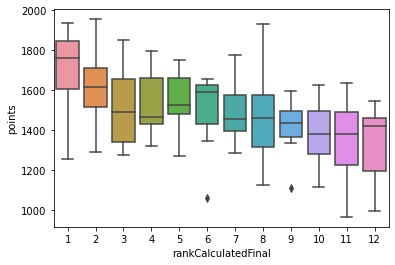

In [63]:
# visualizing points 
fig = sns.boxplot(data=main_df1, y="points", x="rankCalculatedFinal")
# fig.show()

### Step 1.2 Data Engineering 
Now that we have our index, the next step is to craft the features. The best way to approach this is to just go down the list of some of the ideas that were described earlier. By tackling each of those ideas one at a time, it makes the process of engineering features a lot less intimidating. So first on the list is creating a variable that captures each of the picks in the draft:  

- 1_RoundOverallPosition - Last_RoundOverallPosition: For each round, a variable indicating the position that was drafted, and the overall ranking that the player had.   

In order to do this we need to pivot the table to pull out the position that was drafted for any given round:

In [106]:
# positions_map = {1:"QB", 2:"RB", 3:"WR", 4:"TE", 5:"K", 16:"D"}

all_years_draft['defaultPositionId'] = all_years_draft['defaultPositionId'].astype("str")

# pivot the table -- using round id as the column we pivot on and the value is the position that was drafted
draftedpivot = all_years_draft.pivot_table(index=['team_year'], 
                                  columns='roundId', 
                                  values='defaultPositionId',
                                    aggfunc='first')

# renaming for clarity on what column represents
draftedpivot = draftedpivot.add_suffix('RoundOverallPosition')

# getting rid of the index so its a dataframe now
drafted_final = pd.DataFrame(draftedpivot.to_records())

In [122]:
# joining the dataframe to the anchor dataframe
joined_df = pd.merge(main_df1, drafted_final, how="left", on="team_year")

Next I need to extract concate the first 5 picks of the draft for each row.  
- OrderofPositionPicks_5Rounds: A sequential list of positions that were drafted from the first 5 rounds.

In [133]:
# joing the first 5 positions to create a combined list.
first5 = ["1RoundOverallPosition", "2RoundOverallPosition", "3RoundOverallPosition"]
joined_df["OrderofPositionPicks_3Rounds"] = list(joined_df[first5].values)

In [136]:
joined_df['OrderofPositionPicks_3Rounds']

SyntaxError: unexpected EOF while parsing (<ipython-input-136-f793aa0e8066>, line 1)

- AverageDraftPick_Position: The average of all the picks by a position. 

Now that we have a dataframe that sort of captures what I had envisioned, I want to create some other visuals that might give us some preliminary insights into what strategy makes a winning team. 

**How are winning teams drafting? Is there a difference between winning and non-winning teams in drafting strategies?**  

<AxesSubplot:xlabel='LeagueWin_Bin', ylabel='1RoundOverallPosition'>

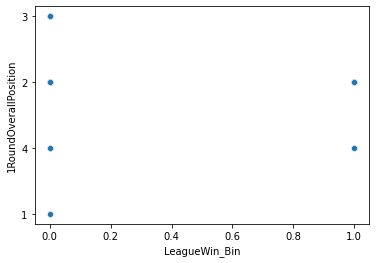

In [72]:
sns.distplot(x = 'LeagueWin_Bin', y = '', data = joined_df)

plt.figure(figsize=(7,5))
sns.distplot(joined_df.1RoundOverallPosition, bins=12, label='Biden')
sns.distplot(anes.fttrump, kde=False, bins=12, label='Trump')
plt.ylabel('Frequency')
plt.xlabel('Thermometer rating')
plt.title('Distribution of Thermometer Ratings')
plt.legend()

### Descriptive Statistics

## Part 2: Building Predictive Models

### Resources   
https://stmorse.github.io/journal/espn-fantasy-python.html  
https://stmorse.github.io/journal/espn-fantasy-3-python.html  
https://cran.r-project.org/web/packages/ffscrapr/vignettes/espn_authentication.html   
https://jman4190.medium.com/how-to-use-python-with-the-espn-fantasy-draft-api-ecde38621b1b